In [ ]:
#!/usr/bin/env python
"""
Definition of test problems
--------------------------------------------------------------------------
Created July 4, 2023 for TRIPs-Py library
"""
__authors__ = "Mirjeta Pasha and Connor Sanderford"
__copyright__ = "Copyright 2022, TRIPs-Py library"
__license__ = "GPL"
__version__ = "0.1"
__maintainer__ = "Mirjeta Pasha and Connor Sanderford"
__email__ = "mirjeta.pasha@tufts.edu; mirjeta.pasha1@gmail.com and csanderf@asu.edu; connorsanderford@gmail.com"

In [1]:
from trips.testProblems import *
from trips.solvers.CGLS import *
#from trips.solvers.arnoldi_tikhonov import *
from trips.solvers.Hybrid_GMRES import *
from trips.solvers.Tikhonov import *
from trips.solvers.GMRES import *
from trips.solvers.golub_kahan_tikhonov import *

#### The test problem when the operator is not built expliictly

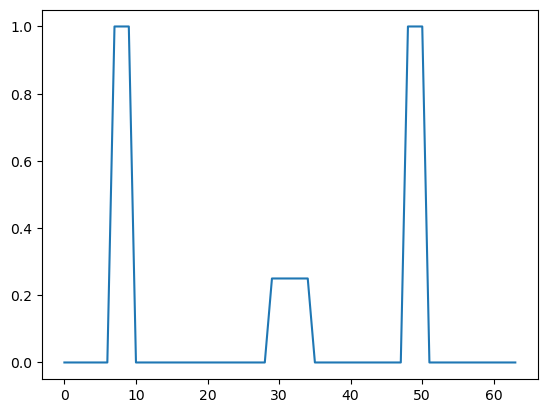

In [2]:
D1D = Deblurring1D()
N = 64
x_true = D1D.gen_xtrue(N, test = 'piecewise')
## If you would like to create the operator only
A = D1D.forward_Op_1D(x_true, blur_type = 'Gaussian', parameter = 0.4) 
## The following creates the data b_true
b_true = D1D.gen_data(x_true, blur_type = 'Gaussian', parameter = 0.4)
(b, delta) = D1D.add_noise(b_true, 'Gaussian', 0.05)
plt.plot(x_true)

### Test a methods

##### 1. CGLS

In [ ]:
(xcgls, info) = TP_cgls(A, b_true, A.T@b, 20, 1e-3, x_true.reshape((-1,1)))
plt.plot(xcgls.reshape((-1,1)))
rel_residual = info['relResidual']
rel_error = info['relError']

In [ ]:

plt.plot(rel_residual)

In [ ]:
plt.plot(rel_error)

#### The test problem when the operator is not built expliictly

In [ ]:
b_vec = b.reshape((-1,1))
xarnoldi_tikhonov = hybrid_gmres(A, b_vec, n_iter = 9, regparam = 'gcv', delta = delta, shape = [64, 64])[0]
outpgcv = hybrid_gmres(A, b_vec, n_iter = 9, regparam = 'gcv', delta = delta, shape = [64, 64])
regpgcv = outpgcv[3]
print(regpgcv)
#plt.plot(xarnoldi_tikhonov)

In [3]:
from scipy import linalg as la
b_vec = b.reshape((-1,1))
print(delta)
deltavar = la.norm(b_vec.reshape((-1,1)) - b_true.reshape((-1,1)))
print(deltavar)

0.12303663062755602
0.123036630627556


In [ ]:
xarnoldi_tikhonov_dp = hybrid_gmres(A, b_vec, n_iter = 9, regparam = 'dp', delta = deltavar, shape = [64, 64])[0]
outpdp = hybrid_gmres(A, b_vec, n_iter = 9, regparam = 'dp', delta = deltavar, shape = [64, 64])
regpdp = outpdp[3]
print(regpdp)

# plt.plot(xarnoldi_tikhonov)

In [ ]:
# plt.plot(xarnoldi_tikhonov)
plt.plot(xarnoldi_tikhonov_dp)
plt.plot(xarnoldi_tikhonov_dpvar)

In [ ]:
xarnoldi_tikhonov_dpvar = hybrid_gmres(A, b_vec, n_iter = 9, regparam = 'dp', dp_stop = True, delta = deltavar, shape = [64, 64])[0]
outpdpvar = hybrid_gmres(A, b_vec, n_iter = 9, regparam = 'dp', dp_stop = True, delta = deltavar, shape = [64, 64])
regpdpvar = outpdpvar[3]
print(regpdpvar)

#### The test problem when the operator is built expliictly

In [ ]:
# The operator A is built as a matrix
## Note: The parameters defining the operators are different, hence different reconstructions
Amat = D1D.forward_Op_matrix_1D(3, N)

In [ ]:
b_true = Amat@x_true
plt.plot(x_true)
D1D.plot_data(b_true)

### Test methods

##### 1. CGLS

In [ ]:
(xcgls, info) = TP_cgls(Amat, b_true, np.zeros((N,1)), 200, 1e-8, x_true)
plt.plot(xcgls.reshape(-1,1))

In [ ]:
rel_err = info['relError']
plt.plot(rel_err)

#### 2. Arnoldi Tikhonov

In [ ]:
reg_param

In [ ]:
(b, delta) = D1D.add_noise(b_true, 'Gaussian', 0.05) # to be redefined again with the b_true corresponding to Amat

In [ ]:
from scipy import linalg as la
print(delta)
# print(la.norm(b.reshape((-1,1)) - b_true.reshape((-1,1))))
deltavar = la.norm(b.reshape((-1,1)) - b_true.reshape((-1,1)))

In [ ]:
b_vec = b.reshape((-1,1))
(xarnoldi_tikhonov, reg_param) = hybrid_gmres(Amat, b_vec, n_iter = 20, regparam = 'dp', delta = delta)
# plt.plot(xarnoldi_tikhonov)

In [ ]:
print(la.norm(Amat@xarnoldi_tikhonov - b_vec.reshape((-1,1))))
print(reg_param)

### 3. Golub-Kahan Tikhonov

In [ ]:
b_vec = b.reshape((-1,1))
(xgolub_kahan_tikhonov, reg_param) = golub_kahan_tikhonov(Amat, b_vec, n_iter = 10, regparam = 'gcv', delta = delta)
plt.plot(xgolub_kahan_tikhonov)

#### 4. GMRES


In [ ]:
xgmres = GMRES(A, b, n_iter = 2, dp_stop = 0)

In [ ]:
plt.plot(xgmres)

In [ ]:
## Define the regularization operator as a matrix here

In [ ]:
from trips.operators import *

In [ ]:
def generate_first_derivative_operator_matrix(n):

    D = sparse.spdiags( data=np.ones(n-1) , diags=-1, m=n, n=n)
    L = sparse.identity(n)-D
    L = L[0:-1, :]

    return L

In [ ]:
L = generate_first_derivative_operator_matrix(4)
L.todense()

In [ ]:
LL = generate_first_derivative_operator_2d_matrix(3,3)